In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
Base.prepare(engine,reflect=True)
# reflect the tables
Base.classes.keys()

['measurement', 'station']

In [7]:
# We can view all of the classes that automap found

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

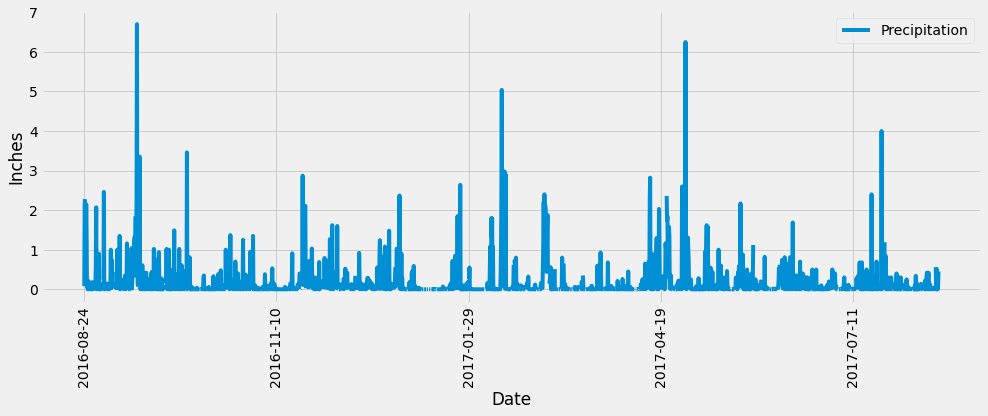

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database

last_date = session.query(func.strftime(Measurement.date)).\
                        order_by(Measurement.date.desc()).first()
           
last_year = dt.datetime.strptime(last_date[0],"%Y-%m-%d")-dt.timedelta(days=365)                      
                                 
# Perform a query to retrieve the data and precipitation scores

last_year_prcp = session.query(func.strftime(Measurement.date),Measurement.prcp).\
                        filter(Measurement.date>= last_year).\
                        order_by(func.strftime(Measurement.date)).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
last_year_prcp_df = pd.DataFrame(last_year_prcp,columns=["Date","Precipitation"])
last_year_prcp_df=last_year_prcp_df.set_index("Date")
# Sort the dataframe by date
last_year_prcp_df.sort_index
# Use Pandas Plotting with Matplotlib to plot the data

ax = last_year_prcp_df.plot(rot=90,figsize=(15,5))
ax.set_ylabel("Inches")
plt.show()

In [11]:
# Use Pandas to calcualte the summary statistics for the precipitation data
last_year_prcp_df.describe()

,Precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [12]:
# Design a query to show how many stations are available in this dataset?
number_of_stations = session.query(Measurement.station).\
                        group_by(Measurement.station).count()
number_of_stations

9

In [13]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
active_stations = session.query(Measurement.station,func.count(Measurement.prcp)).\
                        group_by(Measurement.station).\
                        order_by(func.count(Measurement.prcp).desc()).all()
active_stations

[('USC00519281', 2772),
 ('USC00513117', 2696),
 ('USC00519397', 2685),
 ('USC00519523', 2572),
 ('USC00516128', 2484),
 ('USC00514830', 1937),
 ('USC00511918', 1932),
 ('USC00517948', 683),
 ('USC00518838', 342)]

In [14]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
most_active = active_stations[0][0]
sel = [Measurement.station,
       func.min(Measurement.tobs),
      func.max(Measurement.tobs),
      func.avg(Measurement.tobs)]
most_active_temp = session.query(*sel).\
                        filter(Measurement.station == most_active).all()
most_active_temp

[('USC00519281', 54.0, 85.0, 71.66378066378067)]

In [15]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temp_active_station = session.query(Measurement.station,func.count(Measurement.tobs)).\
                        group_by(Measurement.station).\
                        order_by(func.count(Measurement.tobs).desc()).first()

last_year_temp_active = session.query(Measurement.tobs).\
                        filter(Measurement.date>= last_year).\
                        filter(Measurement.station == temp_active_station[0]).all()


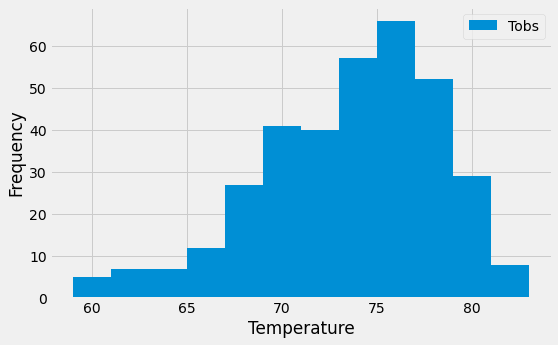

In [16]:
df=pd.DataFrame(last_year_temp_active,columns=["tobs"])
ax = df.hist(bins=12,figsize=(8,5),label="Tobs")
plt.ylabel("Frequency")
plt.xlabel("Temperature")
plt.title("")
plt.legend()
plt.show()

## Bonus Challenge Assignment

### Temperature Analysis I

In [17]:
jun = '06'
dec = '12'
temp_jun = session.query(Measurement.tobs).\
                        filter(func.strftime("%m",Measurement.date)==jun).all()
avg_jun = np.mean(temp_jun)
count_jun=len(temp_jun)
temp_dec=session.query(Measurement.tobs).\
                        filter(func.strftime("%m",Measurement.date)==dec).all()
avg_dec = np.mean(temp_dec)
count_dec = len(temp_dec)
print(f"Average Temperature in June: {avg_jun}. Average Temperature in December: {avg_dec}")

Average Temperature in June: 74.94411764705882. Average Temperature in December: 71.04152933421226


In [18]:
count_jun,count_dec

(1700, 1517)

In [19]:
from scipy import stats

In [20]:
#Since the number of records are different we should use the unpaired t-test version to correct address it

In [21]:
stats.ttest_ind(temp_jun,temp_dec)

Ttest_indResult(statistic=array([31.60372399]), pvalue=array([3.9025129e-191]))

In [22]:
#Since p-value < 0.01, it means there is statistical difference between the avg temperatures of Dec and Jun

### Temperature Analysis II

In [23]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [24]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
end_trip_visit = dt.date(2017,6,11)
end_date = end_trip_visit - dt.timedelta(days=365)
start_date = end_date - dt.timedelta(days=15)
[(tmin,tavg,tmax)]=calc_temps(start_date,end_date)

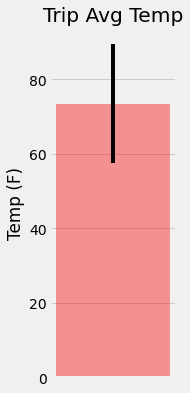

In [25]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
ptp = tmax-tmin
fig=plt.figure(figsize=(2,6))
plt.bar(x=1,height=tavg,yerr=ptp, color="red",alpha=0.4)
plt.xticks([])
plt.ylabel("Temp (F)")
plt.title("Trip Avg Temp")
plt.show()

### Daily Rainfall Average

In [26]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

rainfall_amount = session.query(Measurement.station,func.sum(Measurement.prcp)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).\
        group_by(Measurement.station).all()
rainfall_amount

[('USC00513117', 3.1399999999999997),
 ('USC00514830', 1.4000000000000001),
 ('USC00516128', 8.530000000000001),
 ('USC00517948', None),
 ('USC00519281', 5.04),
 ('USC00519397', 0.9800000000000002),
 ('USC00519523', 3.2499999999999996)]

In [27]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [28]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date

vacations_days=15
dateList=[]

for i in range(0,vacations_days+1):
    dateList.append(start_date + dt.timedelta(days = i))

normals=[]
for date in dateList:
    d=date.strftime('%m-%d')
    normals.append(daily_normals(d))


In [29]:
tmin=[]
tmax=[]
tavg=[]
for i in range(0,len(normals)):
    tmin.append(normals[i][0][0])
    tavg.append(normals[i][0][1])
    tmax.append(normals[i][0][2])

In [30]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
normals_df=pd.DataFrame({"Date":dateList,
                        "tmin":tmin,
                        "tavg":tavg,
                        "tmax":tmax})
normals_df=normals_df.set_index("Date")
normals_df

,tmin,tavg,tmax
Date,,,
2016-05-27,65.0,74.490909,80.0
2016-05-28,67.0,74.277778,82.0
2016-05-29,64.0,74.196078,80.0
2016-05-30,69.0,74.333333,81.0
2016-05-31,68.0,74.400000,81.0
2016-06-01,64.0,74.614035,81.0
2016-06-02,65.0,74.400000,81.0
2016-06-03,65.0,74.034483,80.0
2016-06-04,65.0,73.818182,81.0


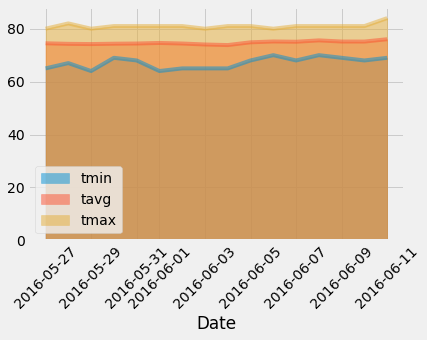

In [31]:
# Plot the daily normals as an area plot with `stacked=False`
ax = normals_df.plot.area(stacked=False, rot=45)